In [1]:
from dataset import DetectionDataset
from utils import plot_images
from default_boxes import *
from utils import xywh2xyxy, draw_rectangles, images_with_rectangles
import matplotlib.pyplot as plt
from iou import calculate_iou

##  MNIST 데이터 다운로드 

In [2]:
# get sample image and object coordinates 
trainset = DetectionDataset(data_type='train')
sample_image, sample_info = trainset[0]
sample_labels = sample_info.iloc[:, 1:5].values
sample_labels = xywh2xyxy(sample_labels)
sample_cls = sample_info.iloc[:, -1].values

## Default boxes 생성

In [3]:
fmap = tf.constant(shape=(2, 8, 8, 2), value=1)
h, w = fmap.get_shape()[1:3]
n_layer = 11
paddings = ['SAME'] * n_layer
strides = [1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2]
kernel_sizes = [3] * n_layer
center_xy = original_rectangle_coords((h, w), kernel_sizes, strides, paddings)[:, :2]

# get w, h
scales = [30]
ratios = [(1, 1),
          (1.5, 0.5),
          (1.2, 0.8),
          (0.8, 1.2),
          (1.4, 1.4)]
sizes = generate_default_boxes(scales, ratios)


# Get default boxes over feature map
default_boxes = tiling_default_boxes(center_xy, sizes)
default_boxes = xywh2xyxy(default_boxes)

## Matching Policy
 - default boxes 중 어떤 default box 을 학습에 사용할지 결정합니다. 
     - 이미지 한장에 대해 수행합니다.
     - default boxes 중 ground turth 와 IOU 가 50 겹쳐지는 default box 만 학습에 사용합니다. 
     - 하나의 default box에 복수개의 박스가 겹친다면 IOU가 가장 높은 데이터를 정답 데이터로 설정 합니다.
     - background class 는 0, 0, 0, 0 으로 설정합니다.  
     - ground truth 중 IOU가 특정 threshold 로 겹치는 default boxes 가 하나도 없다면 

In [4]:
default_boxes = default_boxes.reshape(-1, 4)
sample_labels = sample_labels.reshape(-1, 4)

# 각 obj 별 iou 을 구합니다. 
ious = calculate_iou(default_boxes, sample_labels)

In [5]:
# index 을 실제 클래스로 맵핑합니다. 
max_overlay_cls = np.argmax(ious, axis=-1)

# 모든 obj 에 대해 iou 가 0.5 이하이면 background class, -1로 지정합니다. 
background_mask = np.all(ious < 0.5, axis=-1)
max_overlay_cls[background_mask] = -1

# 기존의 정답 데이터에 [0, 0, 0, 0] 을 추가합니다. 
sample_labels_ = np.concatenate([sample_labels, np.array([[0, 0, 0, 0]])], axis=0)

# index 에 해당하는 ground truth 의 좌표값을 가져옵니다. 
true_reg = sample_labels_[max_overlay_cls]

In [6]:
pos_ious_max = np.max(ious[np.any(ious > 0.5, axis=-1)], axis=-1)

In [7]:
pos_ious_max

array([0.50111111, 0.60804919, 0.53873874, 0.67496203, 0.55727395,
       0.51503519, 0.53388889, 0.55      , 0.51836735, 0.50485221,
       0.67166667, 0.56441718, 0.68892576, 0.68333333, 0.72297838,
       0.51576498, 0.5052739 , 0.54063604, 0.58950924, 0.57146988,
       0.60067397, 0.68773545, 0.52104132, 0.57112971, 0.54789272,
       0.56154195, 0.64060763, 0.67191011, 0.67194648, 0.61694956,
       0.80136467, 0.63826827, 0.51704133, 0.5154334 , 0.57099698,
       0.668506  , 0.61831706, 0.69436548, 0.64777686, 0.52051404,
       0.56861971, 0.62679811, 0.53155579, 0.54736328, 0.81325662,
       0.80467608, 0.86732551, 0.74918888, 0.65216509, 0.67405527,
       0.50123894, 0.59739898, 0.71428571, 0.65981241, 0.50369784,
       0.52026677])

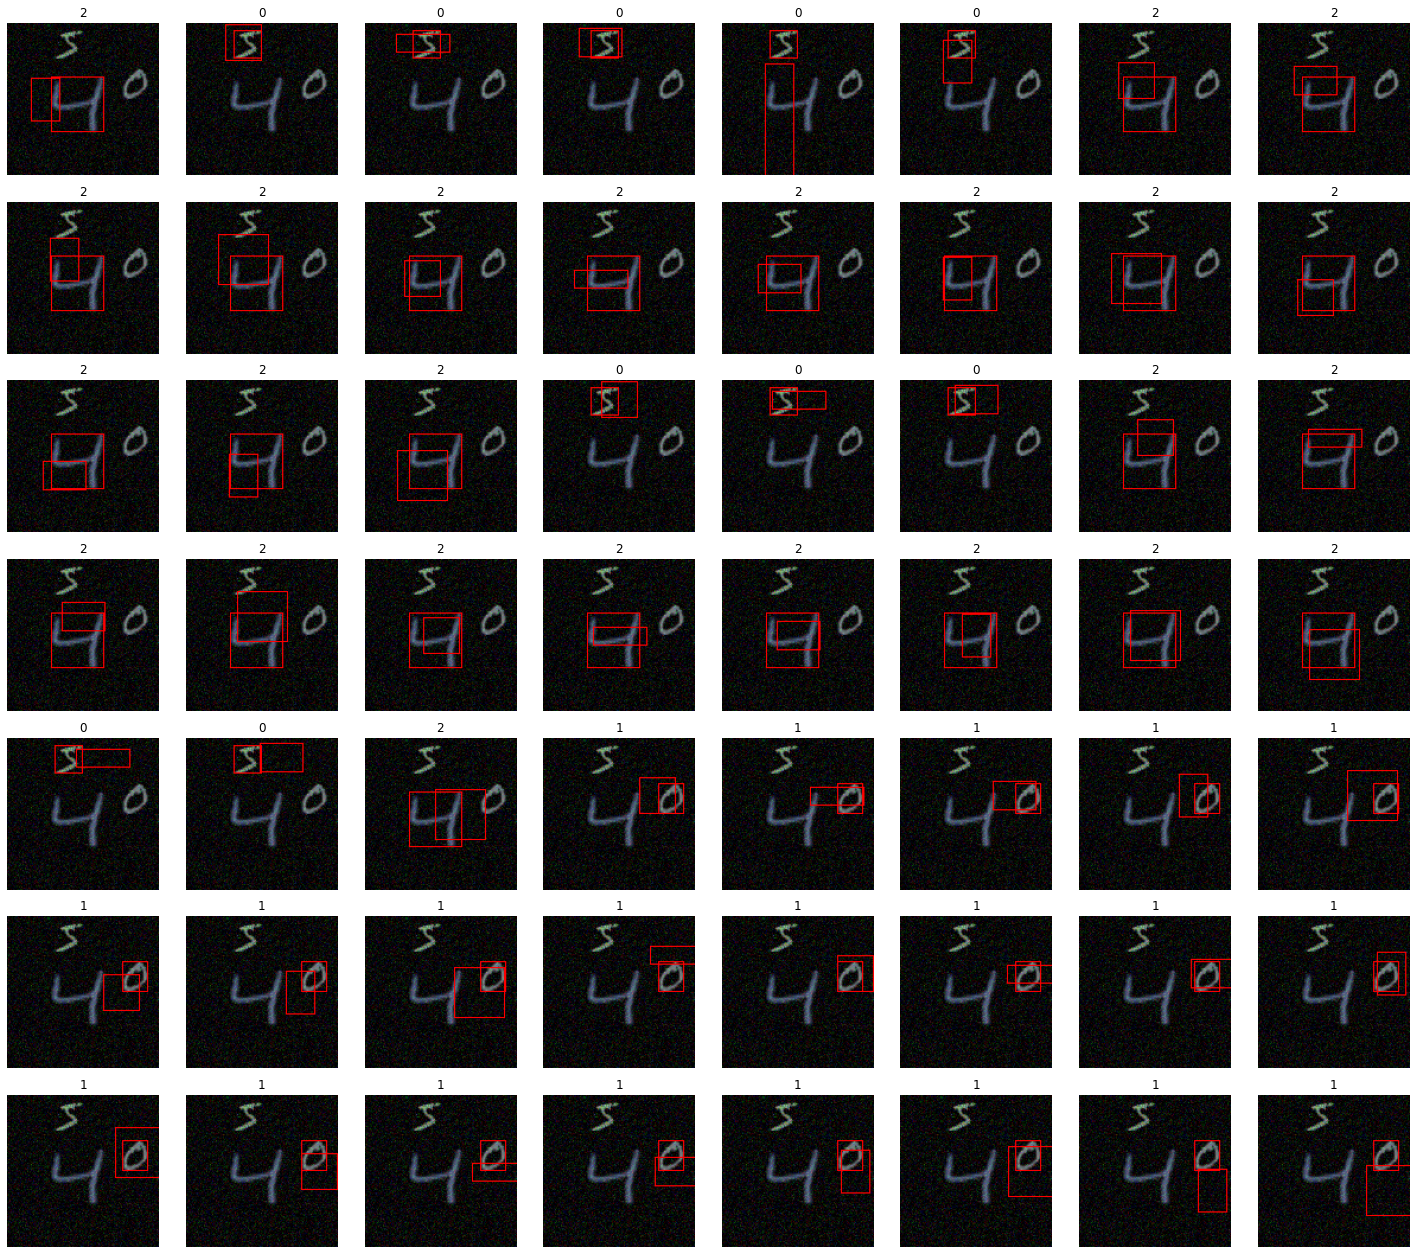

In [9]:
# visualization
pos_mask = np.all(true_reg, axis=-1)

# 객체를 포착한 class 와 coordinates만 가져옵니다
pos_true_cls = max_overlay_cls[pos_mask]
pos_true_reg = true_reg[pos_mask].reshape(-1, 1, 4)
pos_dflt_reg = default_boxes[pos_mask].reshape(-1, 1, 4)

# 각 box 별 이미지를 시각화해 보여줍니다. 
sample_imgs = [sample_image*255]*len(pos_true_reg)
pos_boxes = np.concatenate([pos_true_reg, pos_dflt_reg], axis=1)
rected_imgs = images_with_rectangles(sample_imgs, pos_boxes)
plot_images(rected_imgs, pos_true_cls)


In [11]:
ious[np.any(ious > 0.5, axis=-1)]

array([[0.09998456, 0.02620949, 0.50111111],
       [0.60804919, 0.02820965, 0.1272863 ],
       [0.53873874, 0.03712243, 0.17834395],
       [0.67496203, 0.03305808, 0.15599847],
       [0.55727395, 0.02658072, 0.11191336],
       [0.51503519, 0.0986448 , 0.30268199],
       [0.21074044, 0.15812686, 0.53388889],
       [0.14832922, 0.15547586, 0.55      ],
       [0.29388381, 0.16659338, 0.51836735],
       [0.28      , 0.12015386, 0.50485221],
       [0.08722445, 0.14622586, 0.67166667],
       [0.        , 0.09811589, 0.56441718],
       [0.04645666, 0.1270077 , 0.68892576],
       [0.14320065, 0.16878403, 0.68333333],
       [0.14995947, 0.12591824, 0.72297838],
       [0.01112856, 0.11335578, 0.51576498],
       [0.        , 0.0971747 , 0.5052739 ],
       [0.05160689, 0.13619046, 0.54063604],
       [0.06903785, 0.10994476, 0.58950924],
       [0.57146988, 0.05228171, 0.12996358],
       [0.60067397, 0.07544141, 0.2147915 ],
       [0.68773545, 0.06295098, 0.16183893],
       [0.